In [164]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
# importing libraries
import math
import pandas as pd
import numpy as np
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [166]:
assignment_data = pd.read_csv(r'/content/drive/MyDrive/Docs/Swiggy/Assignment_Data.csv')
delivery = pd.read_csv(r'/content/drive/MyDrive/Docs/Swiggy/Delivery_Partners_Data.csv')

In [167]:
assignment_data.head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
0,2745,180976,2021-02-13 03:08:24.000,2021-02-13 03:38:26.000,0,NaN,2021-02-13 03:01:11.686,2021-02-13 03:43:26.000,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34.000,373.0,37.377569,72.832560
1,9462,280243,2021-02-14 05:06:40.000,2021-02-14 05:31:04.000,0,NaN,2021-02-14 04:54:25.832,2021-02-14 05:36:04.000,516.8,342.5,451.0,3210.0,27,2021-02-14 05:06:40.000,373.0,37.380613,72.796909
2,14071,339813,2021-02-15 02:22:40.000,2021-02-15 02:44:02.000,0,NaN,2021-02-15 02:01:17.864,2021-02-15 02:49:02.000,459.5,418.7,443.0,2910.0,57,2021-02-15 02:22:35.000,373.0,37.372032,72.805871
3,14442,1315348,2021-02-15 03:01:25.000,2021-02-15 03:15:02.000,0,NaN,2021-02-15 02:43:41.129,2021-02-15 03:20:02.000,376.4,332.9,367.3,3210.0,41,2021-02-15 03:00:28.000,373.0,37.371380,72.819992
4,14515,1186729,2021-02-15 03:12:24.000,2021-02-15 03:50:24.000,0,NaN,2021-02-15 02:48:17.074,2021-02-15 03:55:24.000,414.5,334.1,413.2,3210.0,13,2021-02-15 03:12:09.000,373.0,37.369925,72.826764


In [168]:
assignment_data.sample(3)

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
130574,79808,343339,2021-02-26 03:40:17.000,2021-02-26 04:01:52.000,0,NaN,2021-02-26 03:36:05.069,2021-02-26 04:06:52.000,335.0,341.0,343.2,1760.0,31,2021-02-26 03:39:01.000,374.0,37.363865,72.860993
10180,112968,799514,2021-03-04 01:57:20.000,2021-03-04 02:20:44.000,0,NaN,2021-03-04 01:57:05.311,2021-03-04 02:25:44.000,452.0,326.9,418.3,2560.0,20,2021-03-04 01:56:48.000,373.0,37.367834,72.815835
95085,32481,356645,2021-02-18 05:12:40.000,2021-02-18 05:30:19.000,0,NaN,2021-02-18 05:00:18.171,2021-02-18 05:35:19.000,350.6,424.4,341.3,2810.0,33,2021-02-18 05:11:41.000,372.0,37.376613,72.858582


In [169]:
assignment_data.shape

(132394, 17)

There are 132394 rows and 17 columns in the order assignment dataset

In [170]:
assignment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132394 entries, 0 to 132393
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ORDER_ID                  132394 non-null  int64  
 1   DE_ID                     132394 non-null  int64  
 2   ASSIGNMENT_START_TIME     132394 non-null  object 
 3   ASSIGNMENT_END_TIME       132394 non-null  object 
 4   reject_ind                132394 non-null  int64  
 5   reject_type               8048 non-null    object 
 6   PLACED_TIME               132394 non-null  object 
 7   DELIVERED_TIME            131782 non-null  object 
 8   LASTMILE_DISTANCE         132384 non-null  float64
 9   FIRSTMILE_DISTANCE        132238 non-null  float64
 10  LAST_MILE_TIME_PREDICTED  132394 non-null  float64
 11  PAYOUT_MADE_TO_DE         132391 non-null  float64
 12  NUM_PING_COUNT_LAST10MIN  132394 non-null  int64  
 13  LAST_PING_TIME_LAST10MIN  132394 non-null  o

Null values in the columns of order assignment details dataset are present in reject_type, DELIVERED_TIME, LASTMILE_DISTANCE, PAYOUT_MADE_TO_DE, CUSTOMER_ZONE. 
The datatype of ASSIGNMENT_START_TIME, ASSIGNMENT_END_TIME, PLACED_TIME, DELIVERED_TIME are in string format which we need to convert into datetime format. The reject_type column is in categorical format therefore we need to encode that column.

In [171]:
assignment_data['CUSTOMER_ZONE'].unique()

array([373., 375., 668.,  nan, 841., 372., 382., 624., 374.])

In [172]:
len(assignment_data['CUSTOMER_ZONE'].unique())

9

In [173]:
len(assignment_data['DE_ID'].unique())

991

In total there are 991 delivery partners in Swiggy.

In [174]:
delivery.sample(5)

,DE_ID,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
308,176136,01:42,37.403236,72.882232,2019-10-20,624
162,265679,05:42,37.403876,72.930861,2020-05-05,668
236,399609,05:42,37.432837,72.840795,2020-09-20,372
637,182504,06:42,37.362061,72.817775,2019-10-25,372
213,348753,05:42,37.369752,72.896505,2020-08-02,373


In [175]:
delivery.shape

(991, 6)

We have details about 991 delivery partners.

In [176]:
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DE_ID            991 non-null    int64  
 1   SHIFT_END_TIME   991 non-null    object 
 2   DE_HOME_LAT      991 non-null    float64
 3   DE_HOME_LNG      991 non-null    float64
 4   DE_JOINING_DATE  991 non-null    object 
 5   DE_ZONE_ID       991 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 46.6+ KB


There is no null values in the columns of delivery partner details dataset. The datatype of SHIFT_END_TIME, and DE_JOINING_DATE are in string format which we need to convert into datetime format. Rest all the column valuess are in numerical format.

In [177]:
delivery['DE_ZONE_ID'].unique()

array([ 372,  375,  624,  668,  374,  841,  373, 1192])

In [178]:
assignment_data['reject_ind'].value_counts()

0    124346
1      8048
Name: reject_ind, dtype: int64

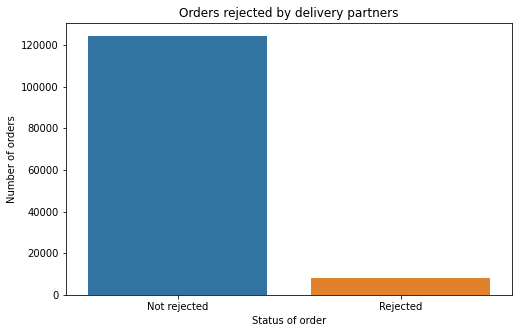

In [179]:
reject_ind_value_counts = dict(assignment_data['reject_ind'].value_counts())
status = ['Not rejected', 'Rejected']
values = list(reject_ind_value_counts.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
sns.barplot(x=status, y=values)

plt.xlabel("Status of order")
plt.ylabel("Number of orders")
plt.title("Orders rejected by delivery partners")
plt.show()

### From the above graph we can see that, the number of orders that are accepted(1) is around 124346, and the number of orders that are rejected(0) is around 8048. So we can there is data imbalance.

In [180]:
assignment_data['reject_type'].value_counts()

Type-1    3853
Type-2    2007
Type-3    1449
Type-4     739
Name: reject_type, dtype: int64

In [181]:
len(assignment_data)-len(assignment_data['ORDER_ID'].unique())

7596

There are 7596 duplicate order IDs

In [182]:
assignment_data['ORDER_ID'].value_counts()[:20]

9795      13
37503     11
59285      8
94836      7
10893      7
43371      7
1750       6
43225      6
102097     6
2119       6
73666      6
2881       6
81805      6
4319       6
104712     6
13890      6
48080      6
32098      6
76237      6
67872      6
Name: ORDER_ID, dtype: int64

We can see that ORDER_ID 9795 has 13 occurences. Let's look at it closely to know the reason behind it.

In [183]:
assignment_data.loc[assignment_data['ORDER_ID']==9795]

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
54744,9795,1161842,2021-02-14 07:00:39.000,2021-02-14 07:30:48.000,0,NaN,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,400.1,487.2,5310.0,8,2021-02-14 07:00:05.000,NaN,37.401954,72.792432
54745,9795,333840,2021-02-14 06:13:24.000,2021-02-14 06:45:44.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,424.1,487.2,0.0,36,2021-02-14 06:11:58.000,NaN,37.401954,72.792432
54746,9795,333840,2021-02-14 06:13:24.000,2021-02-14 06:45:44.975,1,Type-3,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,424.1,487.2,0.0,36,2021-02-14 06:11:58.000,NaN,37.401954,72.792432
54747,9795,978904,2021-02-14 06:46:24.000,2021-02-14 06:48:23.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,397.7,487.2,0.0,9,2021-02-14 06:46:24.000,NaN,37.401954,72.792432
54748,9795,953785,2021-02-14 06:48:24.000,2021-02-14 06:50:33.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,420.8,487.2,0.0,24,2021-02-14 06:48:07.000,NaN,37.401954,72.792432
54749,9795,953785,2021-02-14 06:48:24.000,2021-02-14 06:50:33.857,1,Type-3,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,420.8,487.2,0.0,24,2021-02-14 06:48:07.000,NaN,37.401954,72.792432
54750,9795,1167674,2021-02-14 05:36:40.000,2021-02-14 06:02:51.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432
54751,9795,1167674,2021-02-14 05:36:40.000,2021-02-14 06:02:51.922,1,Type-3,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432
54752,9795,1167674,2021-02-14 06:12:31.000,2021-02-14 06:13:10.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432
54753,9795,1167674,2021-02-14 06:50:42.000,2021-02-14 06:54:29.000,1,Type-1,2021-02-14 05:32:59.753,2021-02-14 07:35:48.000,560.9,393.5,487.2,0.0,10,2021-02-14 05:36:36.000,NaN,37.401954,72.792432


In [184]:
assignment_data.loc[assignment_data['ORDER_ID']==9795]['DE_ID'].unique()

array([1161842,  333840,  978904,  953785, 1167674, 1297294])

This order was assigned to 6 delivery executives and five of them has rejected the order with multiple rejection types.

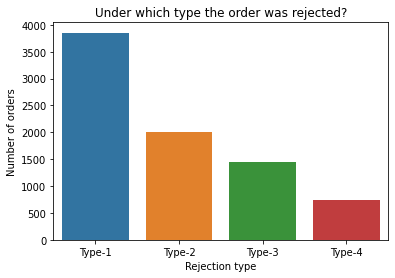

In [185]:
types = dict(assignment_data['reject_type'].value_counts())
sns.barplot(x=list(types.keys()), y=list(types.values()))

plt.xlabel("Rejection type")
plt.ylabel("Number of orders")
plt.title("Under which type the order was rejected?")
plt.show()

**As we can see the rejected orders by delivery partners mostly fall under Type-I rejection.**

**Left join two datasets on the basis of common DE_ID such that we can the delivery partner's information in the order assignment data itself.**

In [186]:
total_df = pd.merge(left=assignment_data, right=delivery, how='left', left_on='DE_ID', right_on='DE_ID')
total_df.sample(5)

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
72708,32591,958725,2021-02-18 05:28:40.000,2021-02-18 05:42:07.000,0,NaN,2021-02-18 05:07:04.224,2021-02-18 05:47:07.000,392.9,320.0,386.0,2310.0,27,2021-02-18 05:28:38.000,841.0,37.360204,72.907378,05:42,37.407984,72.891755,2018-12-14,841
33634,91024,339748,2021-02-28 02:54:33.000,2021-02-28 03:19:43.000,0,NaN,2021-02-28 02:39:05.953,2021-02-28 03:24:43.000,404.3,437.6,388.2,4010.0,22,2021-02-28 02:54:07.000,375.0,37.411103,72.835047,05:42,37.412676,72.853600,2020-07-25,375
65873,104439,386256,2021-03-02 07:07:20.000,2021-03-02 07:29:41.000,0,NaN,2021-03-02 07:06:25.698,2021-03-02 07:34:41.000,473.9,401.3,414.0,3260.0,44,2021-03-02 07:07:04.000,NaN,37.352935,72.845757,06:42,37.375169,72.810405,2020-09-05,373
24461,12878,234637,2021-02-14 23:48:40.000,2021-02-15 00:03:43.000,0,NaN,2021-02-14 23:33:48.293,2021-02-15 00:08:43.000,372.5,418.4,387.2,2360.0,55,2021-02-14 23:47:47.000,375.0,37.420555,72.844178,05:42,37.422587,72.838379,2020-02-17,375
109280,28561,246983,2021-02-17 22:33:39.000,2021-02-17 22:49:09.000,0,NaN,2021-02-17 22:32:58.122,2021-02-17 22:54:09.000,339.5,320.0,332.0,1610.0,36,2021-02-17 22:32:56.000,624.0,37.411296,72.866851,01:42,37.420702,72.876488,2020-04-12,624


In [187]:
total_df.shape

(132394, 22)

The number of rows remain same as it was there previously in order assignment deetails dataset, just that we have added the details of delivery partner in the next columns. Previously there were 17 columns, now it's 22.

In [188]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132394 entries, 0 to 132393
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ORDER_ID                  132394 non-null  int64  
 1   DE_ID                     132394 non-null  int64  
 2   ASSIGNMENT_START_TIME     132394 non-null  object 
 3   ASSIGNMENT_END_TIME       132394 non-null  object 
 4   reject_ind                132394 non-null  int64  
 5   reject_type               8048 non-null    object 
 6   PLACED_TIME               132394 non-null  object 
 7   DELIVERED_TIME            131782 non-null  object 
 8   LASTMILE_DISTANCE         132384 non-null  float64
 9   FIRSTMILE_DISTANCE        132238 non-null  float64
 10  LAST_MILE_TIME_PREDICTED  132394 non-null  float64
 11  PAYOUT_MADE_TO_DE         132391 non-null  float64
 12  NUM_PING_COUNT_LAST10MIN  132394 non-null  int64  
 13  LAST_PING_TIME_LAST10MIN  132394 non-null  o

The data is almost same as it was in order assignment details dataset, there was only addition in delivery partner details and we can see that there are no null values from delivery partner details dataset.

**Feature engineering of datetime data**

In [189]:
total_df['ASSIGNMENT_START_TIME'] = pd.to_datetime(total_df['ASSIGNMENT_START_TIME'], errors = 'coerce')
shift_end = pd.to_datetime(total_df['SHIFT_END_TIME'], errors = 'coerce')
joining = pd.to_datetime(total_df['DE_JOINING_DATE'], errors = 'coerce')

In [190]:
total_df['ASSIGNMENT_START_TIME'].isnull().sum()

0

There is no null values in ASSIGNMENT_START_TIME column.

In [191]:
total_df['ASSIGNMENT_START_TIME'].head()

0   2021-02-13 03:08:24
1   2021-02-14 05:06:40
2   2021-02-15 02:22:40
3   2021-02-15 03:01:25
4   2021-02-15 03:12:24
Name: ASSIGNMENT_START_TIME, dtype: datetime64[ns]

Now, we can see that the data type is converted to datetime.

In [192]:
total_df['ASSIGNMENT_START_TIME_date'] = total_df['ASSIGNMENT_START_TIME'].dt.date
total_df['ASSIGNMENT_START_TIME_time'] = total_df['ASSIGNMENT_START_TIME'].dt.time
total_df['ASSIGNMENT_START_TIME_year'] = total_df['ASSIGNMENT_START_TIME'].dt.year
total_df['ASSIGNMENT_START_TIME_month'] = total_df['ASSIGNMENT_START_TIME'].dt.month
total_df['ASSIGNMENT_START_TIME_day'] = total_df['ASSIGNMENT_START_TIME'].dt.day
total_df['ASSIGNMENT_START_TIME_hour'] = total_df['ASSIGNMENT_START_TIME'].dt.hour
total_df['ASSIGNMENT_START_TIME_minute'] = total_df['ASSIGNMENT_START_TIME'].dt.minute
total_df['ASSIGNMENT_START_TIME_dayofweek'] = total_df['ASSIGNMENT_START_TIME'].dt.dayofweek

total_df['SHIFT_END_TIME'] = shift_end.dt.time
total_df['SHIFT_END_TIME_hour'] = shift_end.dt.hour
total_df['SHIFT_END_TIME_min'] = shift_end.dt.minute

total_df['DE_JOINING_DATE'] = joining.dt.date
total_df['DE_JOINING_DATE_year'] = joining.dt.year
total_df['DE_JOINING_DATE_month'] = joining.dt.month
total_df['DE_JOINING_DATE_day'] = joining.dt.day

Now, we will create two more features - difference between joining date and assignment of order date in months, difference between shift time and assignment of order time in hours

In [193]:
total_df['diff_joining_assign'] = (((total_df['ASSIGNMENT_START_TIME_date']-total_df['DE_JOINING_DATE']).dt.days)/30).astype(int)
total_df['diff_shift_assign'] = (total_df['SHIFT_END_TIME_hour']-total_df['ASSIGNMENT_START_TIME_hour'])

In [194]:
total_df['zone_diff'] = (abs(total_df['CUSTOMER_ZONE']-total_df['DE_ZONE_ID']))

In [195]:
total_df.loc[:, 'zone_diff'].value_counts()

0.0      55593
1.0      10887
3.0       9369
2.0       8039
249.0     5522
469.0     4225
252.0     3483
467.0     3465
44.0      2777
217.0     2699
466.0     1532
173.0     1417
250.0     1184
296.0      931
293.0      779
251.0      676
468.0      670
294.0      415
568.0       75
295.0       44
817.0       23
524.0       13
820.0       10
351.0        6
286.0        6
819.0        6
818.0        3
459.0        2
8.0          1
10.0         1
Name: zone_diff, dtype: int64

In [196]:
total_df.loc[total_df['reject_ind']==0, 'zone_diff'].value_counts().index[:10]

Float64Index([0.0, 1.0, 3.0, 2.0, 249.0, 469.0, 252.0, 467.0, 44.0, 217.0], dtype='float64')

In [197]:
total_df.loc[total_df['reject_ind']==1, 'zone_diff'].value_counts().index[:10]

Float64Index([0.0, 1.0, 3.0, 2.0, 249.0, 44.0, 252.0, 467.0, 217.0, 469.0], dtype='float64')

Therefore we can see that if the zone difference between the delivery executive and the customer zone is around 0-4 then those delivery partners are assigned more orders in this range of zone difference. Also, if the zone difference is too high, delivery partners don't opt for those assigned orders.

In [198]:
total_df['SHIFT_END_TIME'].unique()

array([datetime.time(5, 42), datetime.time(6, 42), datetime.time(1, 42),
       datetime.time(11, 42), datetime.time(8, 42), datetime.time(0, 42)],
      dtype=object)

From the above observation we can see that the shift end time are 6 unique values and as we know that in Swiggy the shift time of a delivery executive starts at 8 am and the delivery system at max continues till 12 am, so we can safely assume that the above timings given are in 12 hr format and all the shift timings end after 12 pm in a day. therefor we will change the time format to 24 hr format. Therefore adding 12 hrs to each of the above time and and 24 to 00 hr.

In [199]:
def shift_hours_add(hour):
  if hour == 0:
    hour = 24
  else:
    hour += 12
  return hour

# Converting SHIFT_END_TIME_hour to 24 hrs format
total_df['SHIFT_END_TIME_hour'] = total_df['SHIFT_END_TIME_hour'].apply(lambda x: shift_hours_add(x))


In [200]:
total_df['SHIFT_END_TIME_hour'].unique()

array([17, 18, 13, 23, 20, 24])

In [201]:
df_reject = total_df.loc[total_df['reject_ind']==1]
# (total_df['ASSIGNMENT_START_TIME_hour']-total_df['SHIFT_END_TIME_hour']).unique()
df_reject['diff_shift_assign'] = (df_reject['SHIFT_END_TIME_hour']-df_reject['ASSIGNMENT_START_TIME_hour'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [202]:
df_reject.loc[df_reject['ASSIGNMENT_START_TIME_hour']<=5].head()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID,ASSIGNMENT_START_TIME_date,ASSIGNMENT_START_TIME_time,ASSIGNMENT_START_TIME_year,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_minute,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,SHIFT_END_TIME_min,DE_JOINING_DATE_year,DE_JOINING_DATE_month,DE_JOINING_DATE_day,diff_joining_assign,diff_shift_assign,zone_diff
38,67253,1186729,2021-02-24 05:14:34,2021-02-24 05:17:33.000,1,Type-2,2021-02-24 05:04:31.363,2021-02-24 05:38:00.000,397.1,447.8,376.5,0.0,9,2021-02-24 05:14:19.000,373.0,37.376211,72.829547,05:42:00,37.386463,72.854589,2019-04-05,372,2021-02-24,05:14:34,2021,2,24,5,14,2,17,42,2019,4,5,23,12,1.0
44,81535,1339906,2021-02-26 05:26:33,2021-02-26 05:30:30.000,1,Type-1,2021-02-26 05:21:48.465,2021-02-26 05:59:32.000,512.9,336.8,417.0,0.0,65,2021-02-26 05:26:18.000,373.0,37.376206,72.814922,06:42:00,37.407575,72.822828,2019-06-11,375,2021-02-26,05:26:33,2021,2,26,5,26,4,18,42,2019,6,11,20,13,2.0
47,86851,263776,2021-02-27 05:32:33,2021-02-27 05:35:33.000,1,Type-4,2021-02-27 05:25:10.639,2021-02-27 06:03:22.000,527.3,405.5,410.8,0.0,16,2021-02-27 05:31:27.000,373.0,37.375672,72.800895,06:42:00,37.425862,72.831065,2020-05-03,375,2021-02-27,05:32:33,2021,2,27,5,32,5,18,42,2020,5,3,10,13,2.0
56,101742,392348,2021-03-02 02:39:20,2021-03-02 02:42:20.000,1,Type-2,2021-03-02 02:32:47.165,2021-03-02 03:32:32.000,556.1,436.7,486.7,0.0,5,2021-03-02 02:31:43.000,373.0,37.376254,72.806285,06:42:00,37.415991,72.831829,2020-09-12,375,2021-03-02,02:39:20,2021,3,2,2,39,1,18,42,2020,9,12,5,16,2.0
103,49534,379318,2021-02-21 03:58:03,2021-02-21 03:58:28.000,1,Type-1,2021-02-21 03:51:40.965,2021-02-21 04:44:49.000,419.3,380.6,399.2,0.0,2,2021-02-21 03:57:47.000,373.0,37.375656,72.828943,06:42:00,37.413824,72.846072,2020-08-30,375,2021-02-21,03:58:03,2021,2,21,3,58,6,18,42,2020,8,30,5,15,2.0


In [203]:
df_reject['SHIFT_END_TIME_hour'].value_counts()

17    3253
18    2560
13     945
20     634
23     497
24     159
Name: SHIFT_END_TIME_hour, dtype: int64

Most of the delivery partners whose shift time ends at 5-6pm tends to reject assigned order.

In [204]:
df_reject['diff_joining_assign'].unique()

array([  28,   23,   20,   10,    5,   33,   32,    6,   25,   26,   22,
          9,    7,   15,   21,   17,   27,   30,   31,   34,   29,   16,
          8,   11,   19,   18,   12,   24, -243,    4,   14])

In [205]:
df_reject['diff_joining_assign'].value_counts()[:10]

6     1262
5     1065
9      776
7      500
23     493
22     492
27     409
26     377
10     308
21     298
Name: diff_joining_assign, dtype: int64

In [206]:
total_df['diff_joining_assign'].value_counts()[:10]

6     20743
5     15519
9     10245
22    10152
7      9045
27     7075
23     6776
26     6250
21     5527
10     5356
Name: diff_joining_assign, dtype: int64

In [207]:
df_3 = total_df.groupby('diff_joining_assign').filter(lambda x: len(x) > 5300)

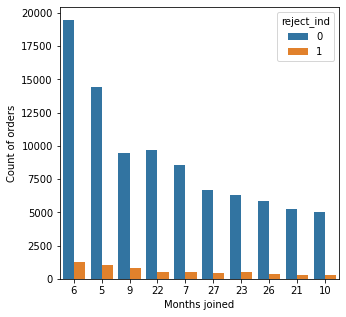

In [208]:
fig = plt.figure(figsize = (5, 5))
sns.countplot(data = df_3,
            x = 'diff_joining_assign',
            hue = 'reject_ind',
            order = df_3['diff_joining_assign'].value_counts().index)

plt.xlabel("Months joined")
plt.ylabel("Count of orders")
plt.show()

We can see that a delivery executive who has joined recently in the last 5-6 months tends to take more orders and these DE also rejects the most number of assigned orders

In [209]:
total_df.loc[total_df['reject_ind']==1].groupby('ASSIGNMENT_START_TIME_dayofweek').size()

ASSIGNMENT_START_TIME_dayofweek
0    1005
1    1102
2    1197
3    1260
4    1190
5    1129
6    1165
dtype: int64

The data is balanced here that means which day of week the order is assigned doesn't affect much the reject in assignmens by delivery partner. 

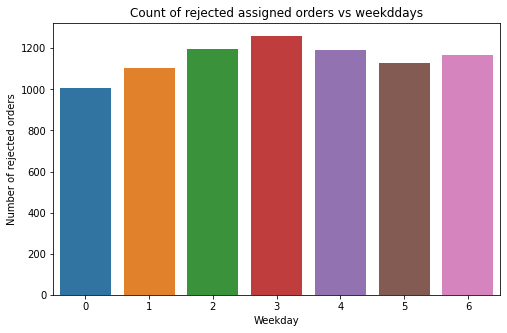

In [210]:
dict1 = dict(total_df.loc[total_df['reject_ind']==1].groupby('ASSIGNMENT_START_TIME_dayofweek').size())
fig = plt.figure(figsize = (8, 5))

sns.barplot(x=list(dict1.keys()), y=list(dict1.values()))

plt.xlabel("Weekday")
plt.ylabel("Number of rejected orders")
plt.title("Count of rejected assigned orders vs weekddays")
plt.show()

Here we can see that maximum rejected assigned orders happen on Thursday whereas least occurs on SUnday.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


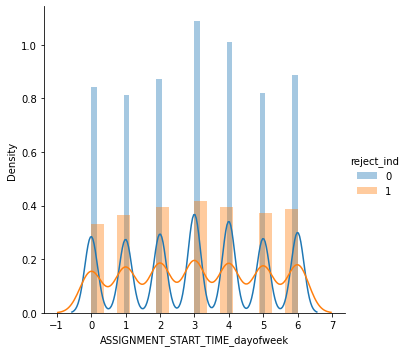

In [211]:
sns.FacetGrid(total_df, hue='reject_ind', size=5).map(sns.distplot, 'ASSIGNMENT_START_TIME_dayofweek').add_legend()
plt.show()

Here from the distribution plot the distribution of rejected assigned orders seems balanced. Maximum number of rejection of assigned orders we have seen previously during Thursday because there are maximum number of total orders on Thursday.

In [212]:
total_df.sample(3)

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID,ASSIGNMENT_START_TIME_date,ASSIGNMENT_START_TIME_time,ASSIGNMENT_START_TIME_year,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_minute,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,SHIFT_END_TIME_min,DE_JOINING_DATE_year,DE_JOINING_DATE_month,DE_JOINING_DATE_day,diff_joining_assign,diff_shift_assign,zone_diff
109039,28487,973327,2021-02-17 22:22:40,2021-02-17 23:01:41.000,0,NaN,2021-02-17 22:22:04.506,2021-02-17 23:06:41.000,374.3,320.0,369.2,1760.0,20,2021-02-17 22:22:37.000,624.0,37.391772,72.891065,05:42:00,37.401440,72.869741,2018-12-21,624,2021-02-17,22:22:40,2021,2,17,22,22,2,17,42,2018,12,21,26,-17,0.0
23922,34913,234637,2021-02-18 21:36:40,2021-02-18 21:45:59.000,0,NaN,2021-02-18 21:34:58.771,2021-02-18 21:50:59.000,348.2,372.5,333.0,1960.0,23,2021-02-18 21:36:38.000,375.0,37.400445,72.847925,05:42:00,37.422587,72.838379,2020-02-17,375,2021-02-18,21:36:40,2021,2,18,21,36,3,17,42,2020,2,17,12,-16,0.0
32044,108999,1194252,2021-03-03 04:40:20,2021-03-03 05:07:04.000,0,NaN,2021-03-03 04:39:49.924,2021-03-03 05:12:04.000,382.7,320.6,362.3,1660.0,77,2021-03-03 04:40:18.000,375.0,37.408698,72.836131,05:42:00,37.396518,72.850196,2019-04-09,375,2021-03-03,04:40:20,2021,3,3,4,40,2,17,42,2019,4,9,23,1,0.0


In [213]:
total_df['ASSIGNMENT_START_TIME'].dt.year.unique()

array([2021])

In [214]:
total_df['ASSIGNMENT_START_TIME_hour'].unique()

array([ 3,  5,  2,  4, 18,  1,  7, 10, 22,  6, 19, 20, 23, 21,  9,  0, 17,
        8, 16, 11, 15, 14, 12])

In [215]:
total_df['ASSIGNMENT_START_TIME_month'].unique()

array([2, 3])

We have data of the month of February and March of year 2021(i.e 12 Feb 2021 to 5 March 2021)

In [216]:
total_df['ASSIGNMENT_START_TIME_dayofweek'].unique()

array([5, 6, 0, 1, 2, 3, 4])

In [217]:
total_df.sort_values(by='ASSIGNMENT_START_TIME_date').groupby(['DE_ID', 'ASSIGNMENT_START_TIME_date']).cumcount()

29959      0
67183      0
67184      0
14177      0
14178      0
          ..
96084      3
96085     11
96086     14
95767     12
132393     9
Length: 132394, dtype: int64

In [218]:
total_df.sample()

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID,ASSIGNMENT_START_TIME_date,ASSIGNMENT_START_TIME_time,ASSIGNMENT_START_TIME_year,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_minute,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,SHIFT_END_TIME_min,DE_JOINING_DATE_year,DE_JOINING_DATE_month,DE_JOINING_DATE_day,diff_joining_assign,diff_shift_assign,zone_diff
101165,7054,365143,2021-02-14 00:43:39,2021-02-14 01:09:21.000,0,NaN,2021-02-14 00:43:05.727,2021-02-14 01:14:21.000,380.0,320.0,369.2,1710.0,28,2021-02-14 00:42:30.000,372.0,37.382521,72.868626,05:42:00,37.384657,72.863781,2020-08-16,372,2021-02-14,00:43:39,2021,2,14,0,43,6,17,42,2020,8,16,6,5,0.0


In [219]:
# importing sklearn and its modules
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import feature_extraction, preprocessing, model_selection, linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import decomposition, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [220]:
df = total_df.drop(['ASSIGNMENT_START_TIME','ORDER_ID','ASSIGNMENT_END_TIME','reject_type','PLACED_TIME','DELIVERED_TIME',
                   'CUSTOMER_LAT','CUSTOMER_LNG','SHIFT_END_TIME','DE_HOME_LAT','DE_HOME_LNG','DE_JOINING_DATE','ASSIGNMENT_START_TIME_year',
                   'ASSIGNMENT_START_TIME_date','ASSIGNMENT_START_TIME_time','CUSTOMER_ZONE','DE_ZONE_ID','zone_diff'], axis = 1)
df.isnull().sum()

DE_ID                                0
reject_ind                           0
LASTMILE_DISTANCE                   10
FIRSTMILE_DISTANCE                 156
LAST_MILE_TIME_PREDICTED             0
PAYOUT_MADE_TO_DE                    3
NUM_PING_COUNT_LAST10MIN             0
LAST_PING_TIME_LAST10MIN             0
ASSIGNMENT_START_TIME_month          0
ASSIGNMENT_START_TIME_day            0
ASSIGNMENT_START_TIME_hour           0
ASSIGNMENT_START_TIME_minute         0
ASSIGNMENT_START_TIME_dayofweek      0
SHIFT_END_TIME_hour                  0
SHIFT_END_TIME_min                   0
DE_JOINING_DATE_year                 0
DE_JOINING_DATE_month                0
DE_JOINING_DATE_day                  0
diff_joining_assign                  0
diff_shift_assign                    0
dtype: int64

In [221]:

df.drop(['LAST_PING_TIME_LAST10MIN','LAST_MILE_TIME_PREDICTED','SHIFT_END_TIME_min','ASSIGNMENT_START_TIME_minute','PAYOUT_MADE_TO_DE','DE_JOINING_DATE_day','DE_ID'],axis =1, inplace = True)

In [222]:
df.sample()

,reject_ind,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,NUM_PING_COUNT_LAST10MIN,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,DE_JOINING_DATE_year,DE_JOINING_DATE_month,diff_joining_assign,diff_shift_assign
61781,1,563.3,374.3,2,3,4,4,3,18,2020,7,7,2


In [223]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 132394 entries, 0 to 132393
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   reject_ind                       132394 non-null  int64  
 1   LASTMILE_DISTANCE                132384 non-null  float64
 2   FIRSTMILE_DISTANCE               132238 non-null  float64
 3   NUM_PING_COUNT_LAST10MIN         132394 non-null  int64  
 4   ASSIGNMENT_START_TIME_month      132394 non-null  int64  
 5   ASSIGNMENT_START_TIME_day        132394 non-null  int64  
 6   ASSIGNMENT_START_TIME_hour       132394 non-null  int64  
 7   ASSIGNMENT_START_TIME_dayofweek  132394 non-null  int64  
 8   SHIFT_END_TIME_hour              132394 non-null  int64  
 9   DE_JOINING_DATE_year             132394 non-null  int64  
 10  DE_JOINING_DATE_month            132394 non-null  int64  
 11  diff_joining_assign              132394 non-null  int64  
 12  di

In [224]:
# Find median of firstmile distance and lastmile distance when reject_ind==1
firstmile_median = df.loc[df['reject_ind']]['FIRSTMILE_DISTANCE'].median(axis=0)
print("Median of FIRSTMILE_DISTANCE: ", firstmile_median)
lastmile_median = df.loc[df['reject_ind']]['LASTMILE_DISTANCE'].median(axis=0)
print("Median of LASTMILE_DISTANCE: ", lastmile_median)

Median of FIRSTMILE_DISTANCE:  320.0
Median of LASTMILE_DISTANCE:  320.9


In [225]:
# filling a null values using fillna() and median values that we have calculated
df['FIRSTMILE_DISTANCE'].fillna(firstmile_median, inplace = True)
df['LASTMILE_DISTANCE'].fillna(lastmile_median, inplace = True)

In [226]:
df.isnull().sum()

reject_ind                         0
LASTMILE_DISTANCE                  0
FIRSTMILE_DISTANCE                 0
NUM_PING_COUNT_LAST10MIN           0
ASSIGNMENT_START_TIME_month        0
ASSIGNMENT_START_TIME_day          0
ASSIGNMENT_START_TIME_hour         0
ASSIGNMENT_START_TIME_dayofweek    0
SHIFT_END_TIME_hour                0
DE_JOINING_DATE_year               0
DE_JOINING_DATE_month              0
diff_joining_assign                0
diff_shift_assign                  0
dtype: int64

In [227]:
arr = ['LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE',
       'NUM_PING_COUNT_LAST10MIN',
       'ASSIGNMENT_START_TIME_day', 'ASSIGNMENT_START_TIME_hour',
      'ASSIGNMENT_START_TIME_dayofweek',
       'SHIFT_END_TIME_hour','DE_JOINING_DATE_year',
       'DE_JOINING_DATE_month', 'diff_joining_assign',
       'diff_shift_assign']

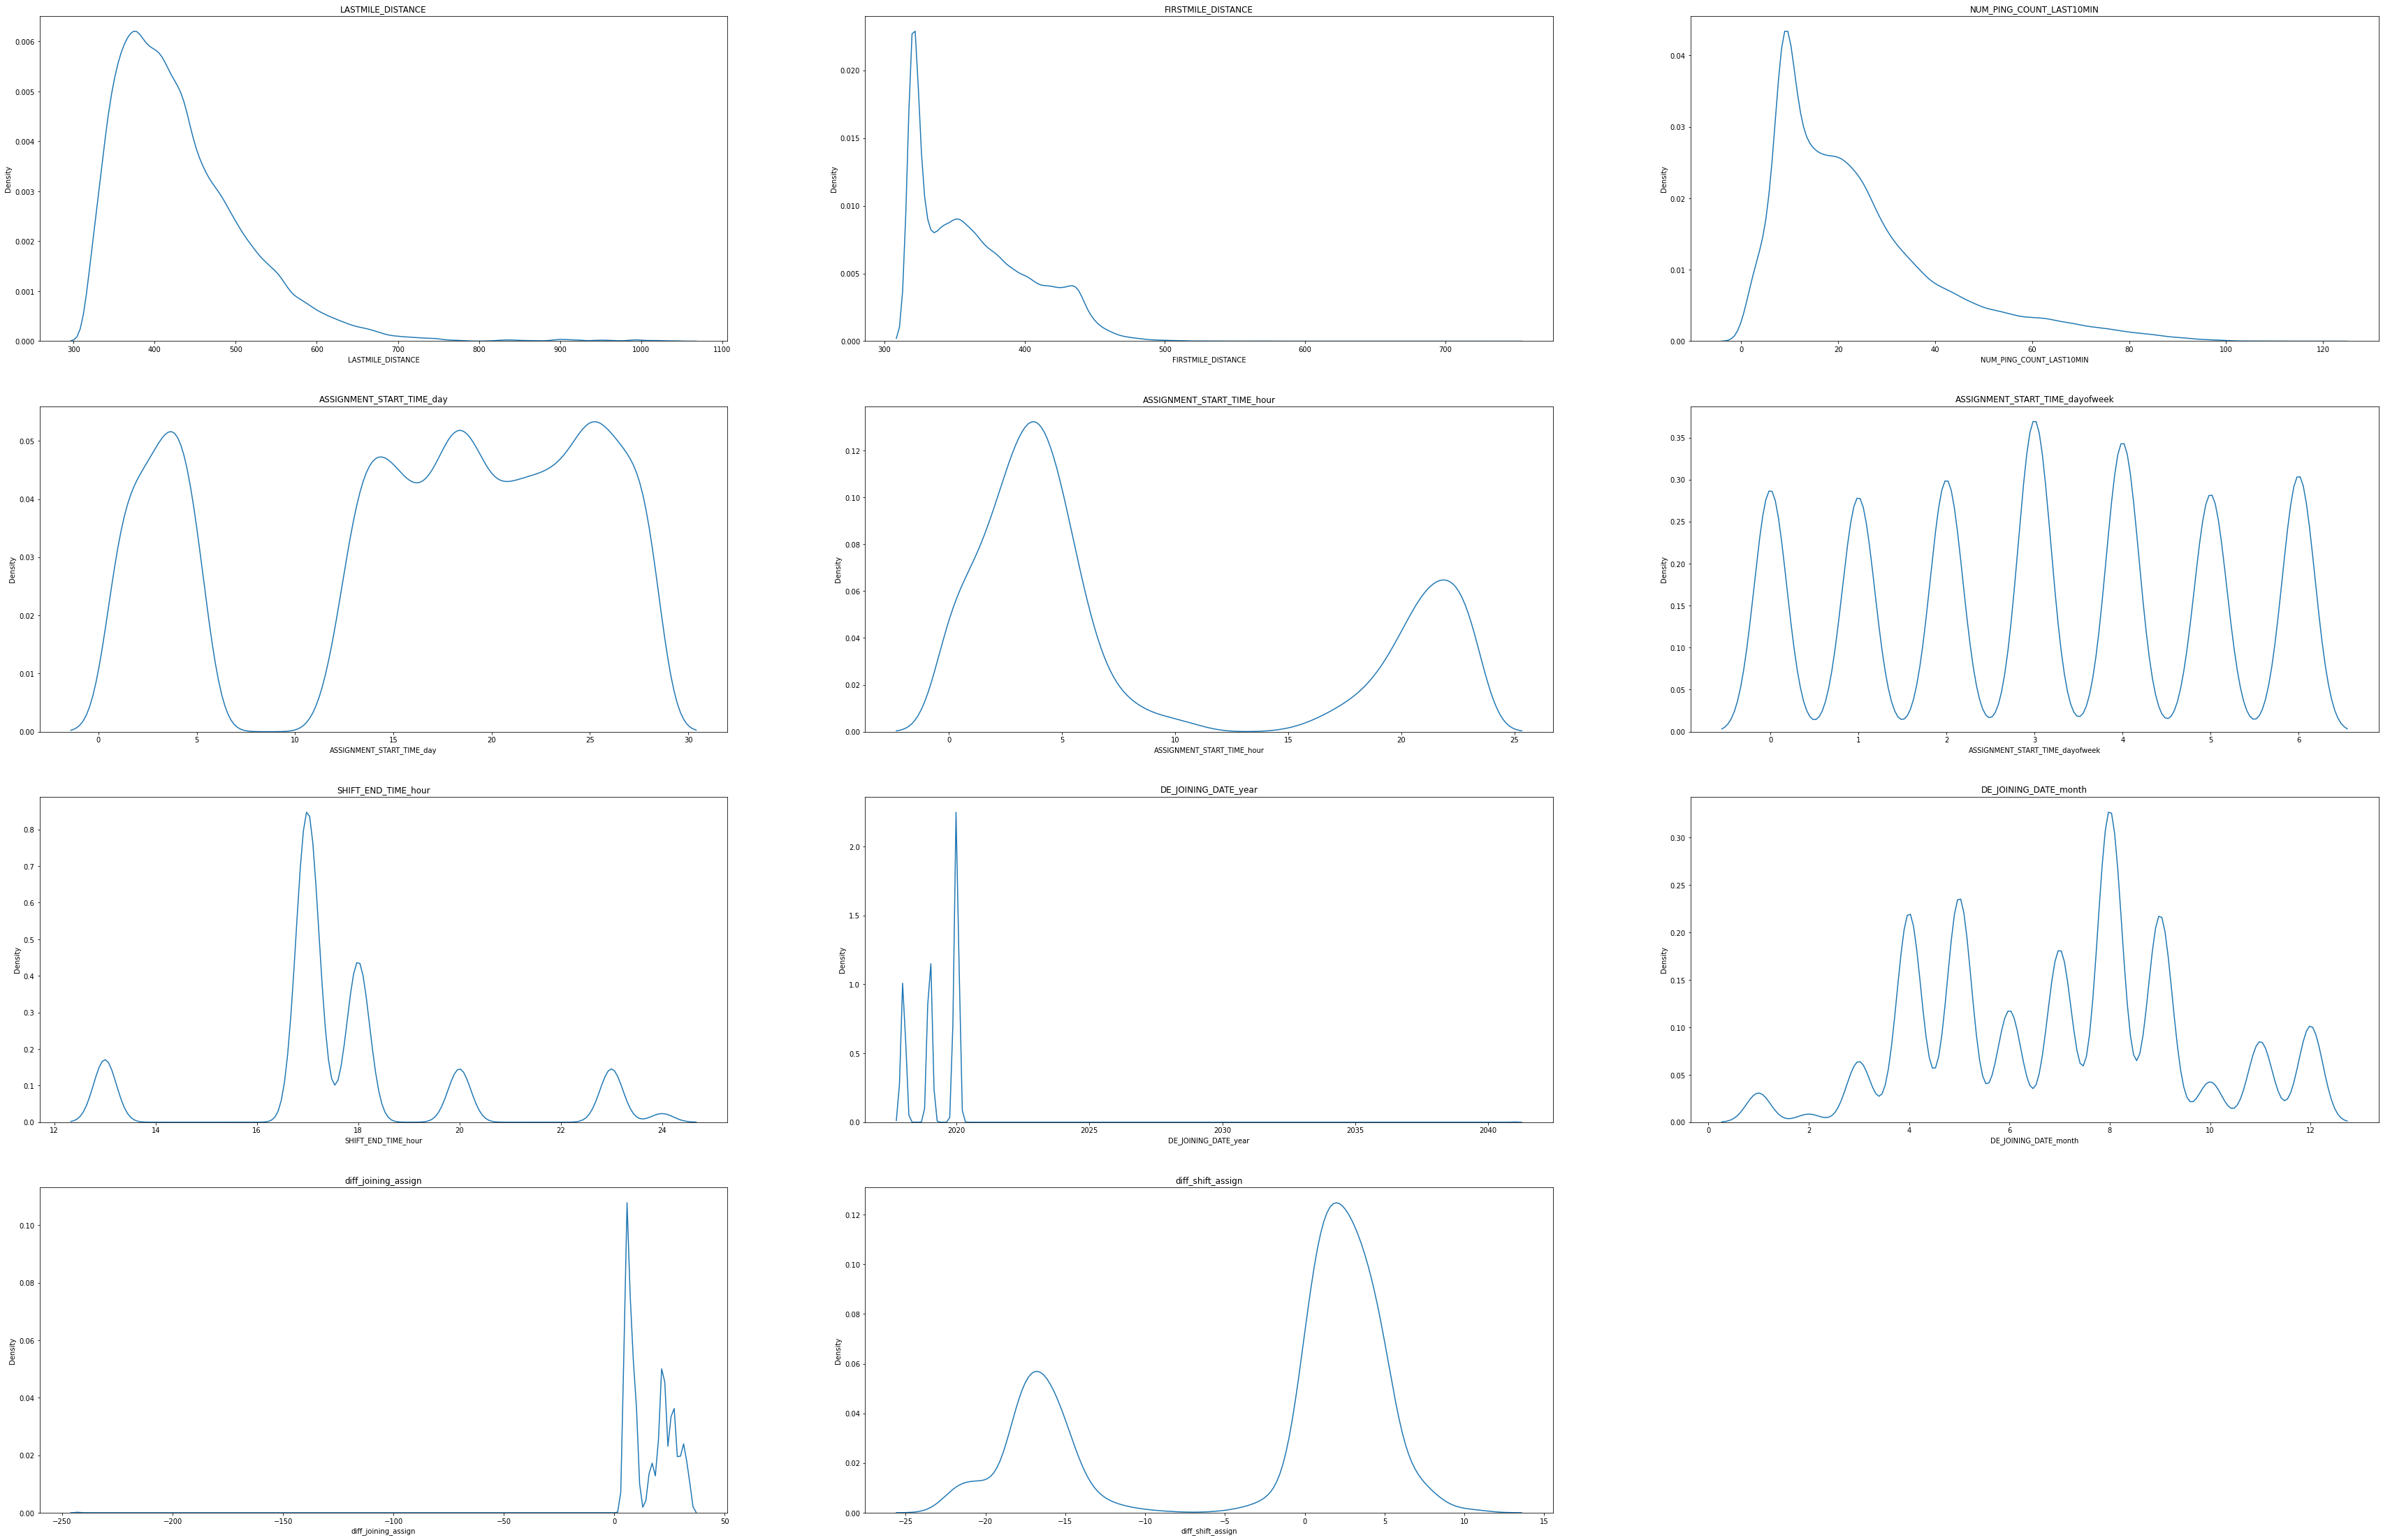

In [228]:
plt.figure(figsize=(60,60)) 

for i in range(len(arr)) : 
  plt.subplot(6,3, i+1)
  sns.kdeplot(df[arr[i]])
  plt.title(str(arr[i]))

In [229]:
skewed_columns = ['LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE',
       'NUM_PING_COUNT_LAST10MIN','diff_joining_assign',
       'diff_shift_assign']

**TRANSFOMING Using YEOJOHNSON**

In [230]:
from scipy.stats import yeojohnson

for i in range(len(skewed_columns)) :
  df[skewed_columns[i]]=yeojohnson(df[skewed_columns[i]])[0]

**LABEL ENCODING**

In [231]:
encode_columns = ['ASSIGNMENT_START_TIME_day', 'ASSIGNMENT_START_TIME_hour',
      'ASSIGNMENT_START_TIME_dayofweek',
       'SHIFT_END_TIME_hour','DE_JOINING_DATE_year',
       'DE_JOINING_DATE_month']  #'DE_JOINING_DATE_day'

In [232]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
for i in range(len(encode_columns)) :
  team_encoder = LabelEncoder()
  df[encode_columns[i]]=team_encoder.fit_transform(df[encode_columns[i]])

KDE PLOT

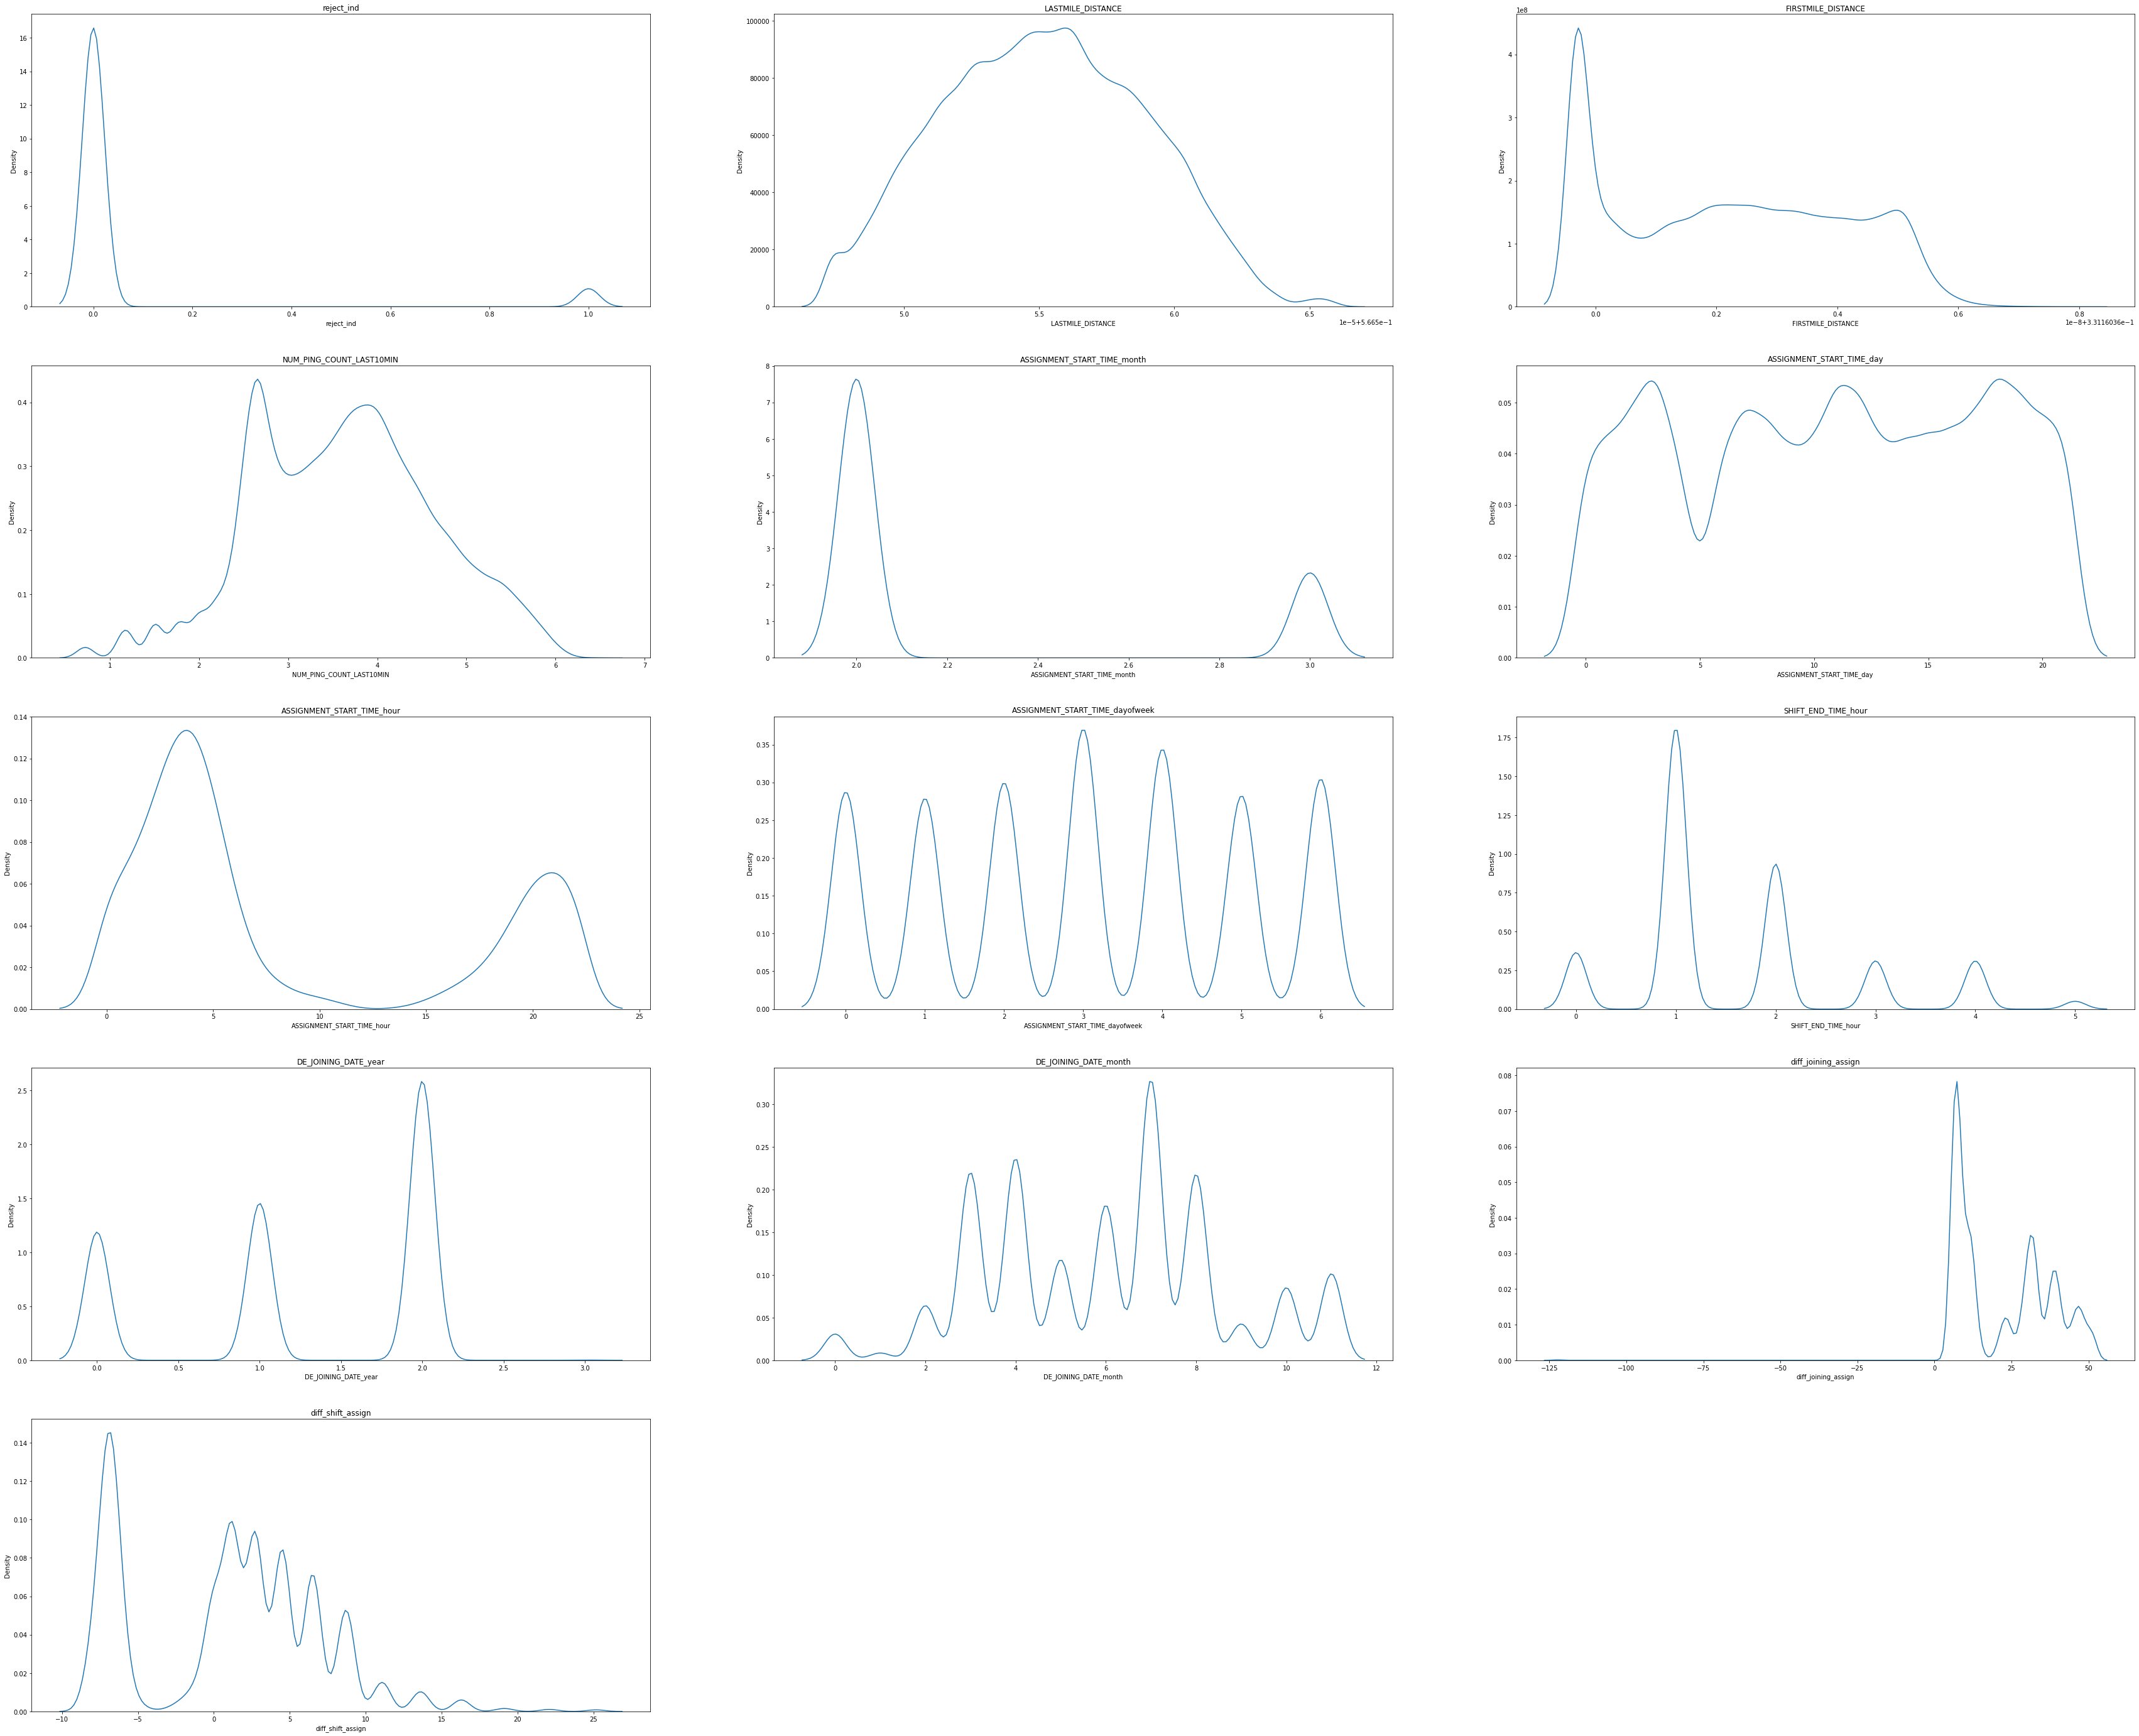

In [233]:
plt.figure(figsize=(60,60)) 

arr = df.columns

for i in range(len(arr)) : 
  plt.subplot(6,3, i+1)
  sns.kdeplot(df[arr[i]])
  plt.title(str(arr[i]))

In [234]:
df.sample(5)

,reject_ind,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,NUM_PING_COUNT_LAST10MIN,ASSIGNMENT_START_TIME_month,ASSIGNMENT_START_TIME_day,ASSIGNMENT_START_TIME_hour,ASSIGNMENT_START_TIME_dayofweek,SHIFT_END_TIME_hour,DE_JOINING_DATE_year,DE_JOINING_DATE_month,diff_joining_assign,diff_shift_assign
95731,0,0.566554,0.33116,4.589842,2,19,2,4,1,2,7,7.322862,4.505093
102185,0,0.566552,0.33116,2.998474,2,17,19,2,1,1,8,23.497901,-6.407840
117365,0,0.566554,0.33116,4.881348,2,11,22,3,4,1,3,31.466731,-5.533504
109207,0,0.566555,0.33116,3.860913,2,8,19,0,1,1,3,31.466731,-6.407840
81623,0,0.566553,0.33116,3.667693,2,20,4,5,1,2,4,11.494903,1.200098


#TRAIN TEST SPLIT

In [235]:
X = (df.drop('reject_ind',axis =1)).values
y = (df['reject_ind']).values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.5)

#USING RANDOM FOREST ON OUR DATA

In [236]:
rf=RandomForestClassifier(max_depth = 5, n_estimators=100)
rf.fit(x_train, y_train)

y_train_preds = rf.predict(x_train)
y_val_preds = rf.predict(x_val)

print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     24870
           1       0.00      0.00      0.00      1609

    accuracy                           0.94     26479
   macro avg       0.47      0.50      0.48     26479
weighted avg       0.88      0.94      0.91     26479



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Our model still is unable to capture the realtion of minority class, we didn't give weights to the target classes yet.

#RANDOM FOREST - using balanced class weights

In [237]:
rf=RandomForestClassifier(max_depth = 5, n_estimators=100, class_weight='balanced')
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [238]:
y_train_preds = rf.predict(x_train)
y_val_preds = rf.predict(x_val)

In [239]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     24870
           1       0.11      0.53      0.18      1609

    accuracy                           0.71     26479
   macro avg       0.53      0.62      0.50     26479
weighted avg       0.91      0.71      0.78     26479



#Random Forest with Balanced_SubSample Class Weights

In [240]:
# define model
rf_2 = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample')

In [241]:
rf_2.fit(x_train, y_train)
y_train_preds_ = rf_2.predict(x_train)
y_val_preds_ = rf_2.predict(x_val)
print(classification_report(y_val, y_val_preds_))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     24870
           1       0.81      0.25      0.38      1609

    accuracy                           0.95     26479
   macro avg       0.88      0.62      0.68     26479
weighted avg       0.94      0.95      0.94     26479



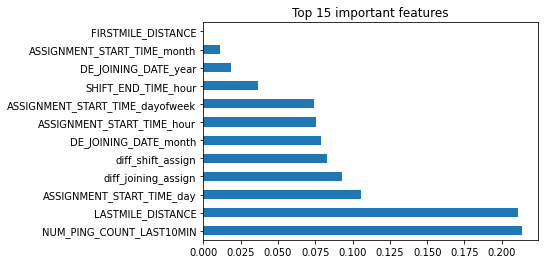

In [242]:
feat_importances = pd.Series(rf_2.feature_importances_, index= df.drop('reject_ind',axis =1).columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

### We can see NUM_PING_COUNT_LAST10MIN and LASTMILE_DISTANCE are the most important features for this model.




#KNN with SMOTE and Standard Scaling

In [253]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline as pp
knn = KNeighborsClassifier(n_neighbors =7)
pipe=pp([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors =7))])


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
pipe.fit(X, y)

y_val_preds_ = pipe.predict(x_val)
print(classification_report(y_val, y_val_preds_))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     24870
           1       0.25      1.00      0.40      1609

    accuracy                           0.82     26479
   macro avg       0.63      0.90      0.65     26479
weighted avg       0.95      0.82      0.86     26479



***

* I have chosen the recall of 1 as my evaluation metrics because recall is 
important for us because since it helps us maintain all the relevant instances in our data as we have to avoid rejections we have to know whe DE is going to reject the order correctly which recall of 1 tell us.

* Recall = TruePositives / (TruePositives + FalseNegatives)

* A recall of 1.0 means that every item from class "reject_ind=1" was labelled as belonging to class "reject_ind=1". 

* So,KNN with SMOTE and Standard Scaling is best preffered to predict rejections.
***

OBSERVATIONS:

1.The data is imbalanced heavily with class 0 having around 120000 rows and class 1 having 8048 rows.

2.The end_shift_time of the delivery boy was not clear, the time was not in 24 hrs format neither it was mentioned whether the shift ends at am or pm. Assuming that the shift starts at 8 am and end at 12 am, the time was chaned to 24 hrs format. We observed that when the DE gets order when his/her shift_end_time is near, the DE tends to reject the assigned order.

3.Type-3 Error always comes with Type-1 Error (i.e If there is type-3 error, it is complusory to have Type-1 error given by DE)

4.After doing a lot of analysis on the data we understood when a delivery agent is new, he tends to deliver more orders as compared to someone who has been working for 2-3 years. Possibly since that person takes so many orders often the delivery executive assignment system assigns them more orders which sometimes lead to rejection of the order.

5.At a particlar shift of the day the surge in customers ordering food is high, and maybe due to excessive offers the DE get during that time the number of assigned orders rejected are more during that time. We can possibly make sure that during that partcular time we have maximum number of DE and not much DE's shifts end during that time. This will help us deal with huge customers during that time without disappointing them with much waiting time making better customer experience.

6.Using shift_end_time and assignment_order_time we can get the dead_hour of the DE and see if a DE rejects more orders during his/her dead hour. Dead hour is the hour in which the shift_end_time of the DE is near. From the patterns we can see which DE tend to reject more offer during their dead_hour.

7.In a day every DE must have limits and patterns in the number of orders they deliver. One DE might take 20 orders per day whereas another might take 10 orders at maximum. We can track how many orders in a day a DE is delivering, if they feels like they have exhausted one day's work then they might reject order after that.

8.If Assignment_start_time is closer to DE shift_end_time then DE is preferred to reject the order(from kde plot).

